# Tutorial 2: Bird Migration Analysis


This tutorial uses data published on Movebank, specifically: [Navigation experiments in lesser black-backed gulls (data from Wikelski et al. 2015)-gps.csv](https://www.datarepository.movebank.org/handle/10255/move.494)

This tutorial covers: 
1. Trajectory data preprocessing
 1. Loading movement data from common geospatial file formats
 1. Exploring spatial & non-spatial data distributions
 1. Converting GeoDataFrames into Trajectories describing continuous tracks of moving objects
1. Trajectory data analysis
 1. Investigating individual trajectories
 1. Comparing different years
 1. Investigating trajectories of multiple individuals
 1. Tagging trajectories by places they pass through

In [1]:
%matplotlib inline

In [2]:
import urllib
import os
import pandas as pd
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import movingpandas as mpd

import warnings
warnings.simplefilter("ignore")

## Loading the bird movement data 


In [3]:
%%time
df = read_file('data/demodata_gulls.gpkg')
wgs84 = df.crs
df['t'] = pd.to_datetime(df['timestamp'])
df = df.set_index('t')
print("Finished reading {}".format(len(df)))

Finished reading 89867
Wall time: 2.38 s


This is what the data looks like:

In [4]:
df.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
t,,,,,,,,,,,
2009-05-27 14:00:00,1082620685,true,2009-05-27 14:00:00.000,24.58617,61.24783,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58617 61.24783)
2009-05-27 20:00:00,1082620686,true,2009-05-27 20:00:00.000,24.58217,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58217 61.23267)
2009-05-28 05:00:00,1082620687,true,2009-05-28 05:00:00.000,24.53133,61.18833,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.53133 61.18833)
2009-05-28 08:00:00,1082620688,true,2009-05-28 08:00:00.000,24.58200,61.23283,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.582 61.23283)
2009-05-28 14:00:00,1082620689,true,2009-05-28 14:00:00.000,24.58250,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.5825 61.23267)


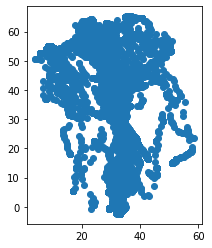

In [5]:
df.plot()

Let's see how many individuals we have in the dataset:

In [6]:
df['individual-local-identifier'].unique()

array(['91732A', '91733A', '91734A', '91735A', '91737A', '91738A',
       '91739A', '91740A', '91741A', '91742A', '91743A', '91744A',
       '91745A', '91746A', '91747A', '91748A', '91749A', '91750A',
       '91751A', '91752A', '91754A', '91755A', '91756A', '91758A',
       '91759A', '91761A', '91762A', '91763A', '91764A', '91765A',
       '91766A', '91767A', '91769A', '91771A', '91774A', '91775A',
       '91776A', '91777A', '91778A', '91779A', '91780A', '91781A',
       '91782A', '91783A', '91785A', '91786A', '91787A', '91788A',
       '91789A', '91794A', '91795A', '91797A', '91798A', '91799A',
       '91800A', '91802A', '91803A', '91807A', '91809A', '91810A',
       '91811A', '91812A', '91813A', '91814A', '91815A', '91816A',
       '91819A', '91821A', '91823A', '91824A', '91825A', '91826A',
       '91827A', '91828A', '91829A', '91830A', '91831A', '91832A',
       '91835A', '91836A', '91837A', '91838A', '91839A', '91843A',
       '91845A', '91846A', '91848A', '91849A', '91852A', '9185

The records per individual are not evenly distributed:

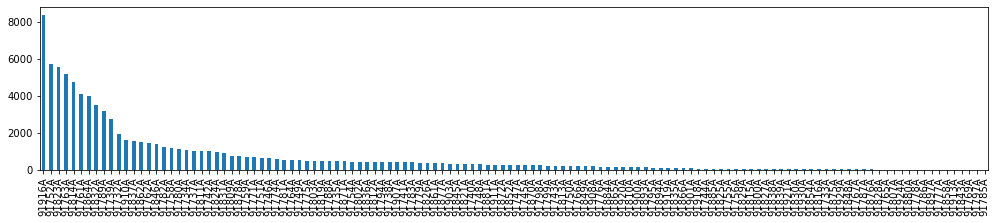

In [7]:
df['individual-local-identifier'].value_counts().plot(kind='bar', figsize=(17,3))

Finally, let's create trajectories:

In [8]:
MIN_LENGTH = 100 # meters

tm = mpd.TrajectoryManager(df, 'individual-local-identifier', MIN_LENGTH)     
all_trajectories = tm.trajectories
    
print("Finished creating {} trajectories".format(len(all_trajectories)))

Finished creating 125 trajectories


## Investigating individual trajectories

Let's pick out a specific individual. For example, '91916A' is the individual with most records in our dataset:

In [9]:
filtered = tm.filter('individual-local-identifier', '91916A')
my_traj = filtered.trajectories[0]
my_traj.df.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
t,,,,,,,,,,,
2009-08-15 15:00:00,1082625177,true,2009-08-15 15:00:00.000,7.91500,54.18533,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (7.915 54.18533)
2009-08-15 21:00:00,1082625178,true,2009-08-15 21:00:00.000,7.91867,54.18467,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (7.91867 54.18467)
2009-08-16 06:00:00,1082625179,true,2009-08-16 06:00:00.000,8.06467,54.29600,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (8.06467 54.296)
2009-08-16 09:00:00,1082625180,true,2009-08-16 09:00:00.000,8.69100,54.53683,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (8.691000000000001 54.53683)
2009-08-16 15:00:00,1082625181,true,2009-08-16 15:00:00.000,9.44183,54.87233,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (9.44183 54.87233)


Conveniently, the plot function can automatically compute tavel speed and visualize it:

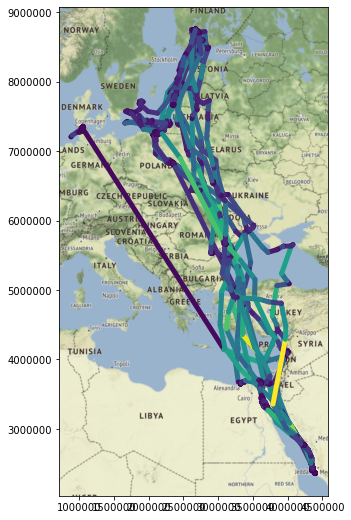

In [10]:
my_traj.plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', figsize=(9,9), url=ctx.sources.ST_TERRAIN) 

This individual has been travelling back and forth for quite a few years!

One way to take a closer look at this individual's travels is to split the overall track into yearly trips:

In [11]:
trips_by_year = filtered.split_by_date(mode='year')
for trip in trips_by_year.trajectories:
    print(trip.id)

91916A_2009
91916A_2010
91916A_2011
91916A_2012
91916A_2013
91916A_2014
91916A_2015


Now we can explore individual years:

In [12]:
one_year = trips_by_year.get_trajectory('91916A_2010')
print(one_year)

Trajectory 91916A_2010 (2010-01-01 04:00:00 to 2010-12-31 19:00:00) | Size: 1381 | Length: 20853237.3m
Bounds: (17.88533, 21.02, 39.26733, 61.54733)
LINESTRING (39.16833 21.16633, 39.18983 21.1125, 39.1805 21.13, 39.18417 21.17583, 39.16717 21.15817


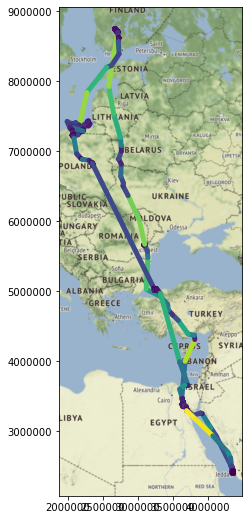

In [13]:
one_year.plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', figsize=(9,9), url=ctx.sources.ST_TERRAIN)

Let's see where this individual was on a specific day:

In [14]:
def plot_location_at_timestamp(traj, t):
    pos = traj.get_position_at(t)
    loc = GeoDataFrame(pd.DataFrame([{'geometry': pos, 'id': traj.id}]), crs=traj.crs)
    ax = loc.to_crs(epsg=3857).plot(markersize=150, figsize=(9,9))
    ax = traj.plot(ax=ax, with_basemap=True, linewidth=2.0, capstyle='round', color='black', figsize=(9,9), url=ctx.sources.ST_TONER_LITE)
    return ax

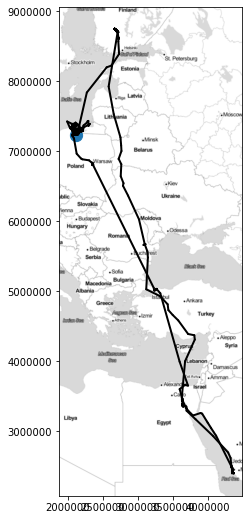

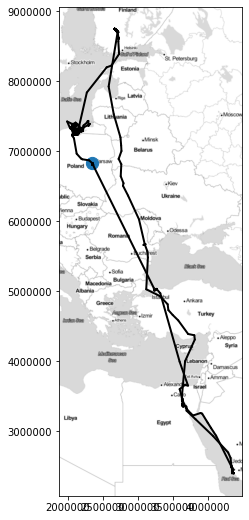

In [15]:
plot_location_at_timestamp(one_year, datetime(2010,9,1))
plot_location_at_timestamp(one_year, datetime(2010,10,1))

Of course, it might also be of interest to see the different locations on a certain day each year:

In [16]:
def plot_location_at_day_of_year(traj, month, day, ax=None):
    ts = [datetime(year, month, day) for year in traj.df.index.year.unique()]
    return plot_locations_at_timestamps(traj, ts, ax=ax)

def plot_locations_at_timestamps(traj, ts, ax=None):  
    loc = get_locations_at_timestamps(traj, ts)
    ax = loc.to_crs(epsg=3857).plot(ax=ax, column='id', legend=True, markersize=150, figsize=(9,9))
    ax = traj.plot(ax=ax, with_basemap=True, linewidth=1.0, capstyle='round', color='black', figsize=(9,9), url=ctx.sources.ST_TONER_LITE)
    return ax    

def get_locations_at_timestamps(traj, ts):
    pos = []
    for t in ts:
        if t > traj.get_start_time() and t < traj.get_end_time():
            pos.append({'geometry': traj.get_position_at(t), 'id': str(t.date())})
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

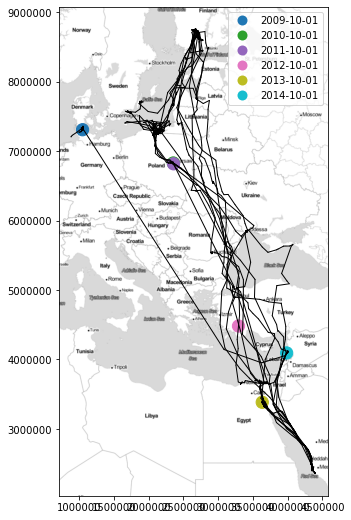

In [17]:
plot_location_at_day_of_year(my_traj, month=10, day=1)

It's pretty clear that this individual does not follow the same schedule and route every year. However, it seems to always be heading to the same area Red Sea coast to spend the winter there.

Let's find its arrival times in this area:

In [18]:
area_of_interest = Polygon([(30, 25), (50, 25), (50, 15), (30, 15), (30, 25)])

In [19]:
arrivals = []
for traj in my_traj.clip(area_of_interest):
    arrivals.append(traj)

print("Found {} arrivals".format(len(arrivals)))

for traj in arrivals:
    print("Individual '{}' arrived at {}".format(traj.df['individual-local-identifier'].iloc[0], traj.get_start_time()))

Found 6 arrivals
Individual '91916A' arrived at 2009-12-22 20:52:54.626917
Individual '91916A' arrived at 2010-10-30 17:21:19.353871
Individual '91916A' arrived at 2011-11-09 16:58:03.402293
Individual '91916A' arrived at 2012-10-14 05:27:27.457627
Individual '91916A' arrived at 2013-10-07 16:01:58.140845
Individual '91916A' arrived at 2014-10-28 17:14:36.791386


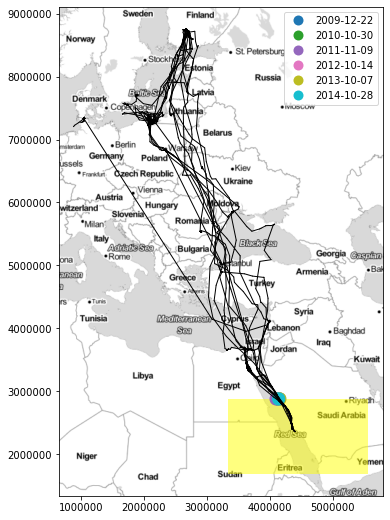

In [20]:
def plot_wgs84_polygon(polygon, ax=None, color=None):
    gdf = GeoDataFrame(pd.DataFrame([{'geometry': polygon, 'id': 1}]), crs=wgs84)
    ax = gdf.to_crs(epsg=3857).plot(ax=ax, color=color, figsize=(9,9), alpha=0.5)
    return ax

ax = plot_wgs84_polygon(area_of_interest, color='yellow')
plot_locations_at_timestamps(my_traj, [traj.get_start_time() for traj in arrivals], ax)

## Investigating trajectories of multiple individuals

Multiple individuals travel to this area every year. Let's have a closer look:

In [21]:
def get_trajectories_by_year(trajs, year):
    result = []
    for traj in trajs:
        if traj.get_start_time().year <= year_of_interest and traj.get_end_time().year >= year_of_interest:
            result.append(traj)
    return result

In [22]:
year_of_interest = 2010

arrivals = []
for individual in all_trajectories:
    for segment in individual.clip(area_of_interest):
        arrivals.append(segment)

relevant = get_trajectories_by_year(arrivals, year_of_interest)
print("Found {} arrivals".format(len(relevant)))

Found 16 arrivals


In [23]:
for traj in relevant:
    print("Individual '{}' arrived at {} (duration: {})".format(
        traj.df['individual-local-identifier'].iloc[0], traj.get_start_time().date(), 
        traj.get_end_time()-traj.get_start_time()))

Individual '91732A' arrived at 2010-04-10 (duration: 5 days, 20:37:26.369600)
Individual '91737A' arrived at 2009-12-08 (duration: 140 days, 13:17:15.897388)
Individual '91761A' arrived at 2010-04-11 (duration: 12 days, 8:35:24.344520)
Individual '91761A' arrived at 2010-10-04 (duration: 6 days, 16:31:22.458041)
Individual '91762A' arrived at 2010-04-19 (duration: 41 days, 21:55:41.827660)
Individual '91771A' arrived at 2009-12-23 (duration: 66 days, 13:31:36.113308)
Individual '91789A' arrived at 2009-11-11 (duration: 550 days, 17:05:36.504463)
Individual '91824A' arrived at 2010-05-05 (duration: 21:11:04.615385)
Individual '91832A' arrived at 2010-04-21 (duration: 3 days, 4:07:12.752774)
Individual '91832A' arrived at 2010-09-23 (duration: 1 day, 1:03:34.780915)
Individual '91837A' arrived at 2010-05-03 (duration: 1 day, 20:34:33.449282)
Individual '91846A' arrived at 2010-05-15 (duration: 10 days, 9:23:20.164439)
Individual '91862A' arrived at 2010-01-06 (duration: 248 days, 8:04:49

Based on the duration of the individuals' trajectory segments within our area of interest, it looks like some individuals spend the winter here while others only pass through.

For example, Individual '91761A' passed through twice? What has it been up to?

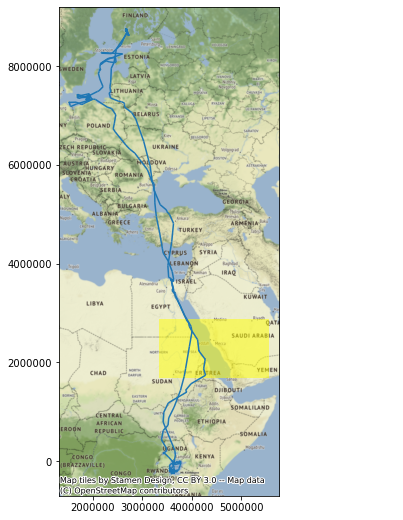

In [24]:
def get_individual_traj_for_year(trajs, id, year):
    individual = tm.get_trajectory(id)
    return individual.get_segment_between(datetime(year,1,1), datetime(year,12,31))

ax = plot_wgs84_polygon(area_of_interest, color='yellow')
get_individual_traj_for_year(all_trajectories, '91761A', year_of_interest).plot(ax=ax, with_basemap=True)

Turns out that this individual does not stay at the Red Sea but continues its journey into Africa.

Let's have a closer look at the trajectory segments within our area of interest:

In [25]:
def place_to_point(place):
    pt = place.geocode
    return Point(pt.longitude, pt.latitude)

def plot_place(place, buffer_size=1, color='green', ax=ax):
    pt = place_to_point(place)
    if place.search in place_to_color.keys():
        color = place_to_color[place.search]
    return plot_wgs84_polygon(pt.buffer(buffer_size,2), ax=ax, color=color)

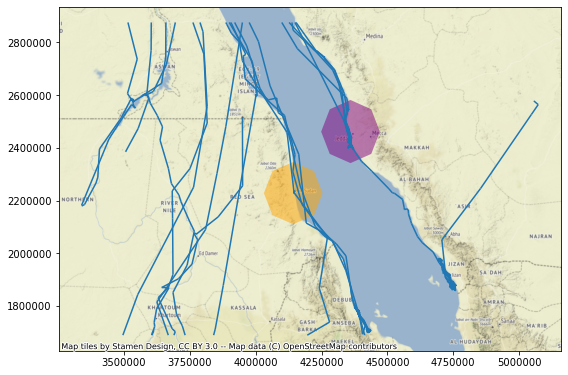

In [26]:
ax = plt.figure(figsize=(9,9)).add_subplot(1,1,1)
        
for traj in relevant:
    ax = traj.plot(ax=ax, for_basemap=True)

places = [ctx.Place(name) for name in ['Jeddah', 'Port Sudan']]
place_to_color = {'Jeddah': 'purple', 'Port Sudan': 'orange', 'Other': 'gray'}

for place in places:
    plot_place(place, ax=ax)    

ctx.add_basemap(ax)

In [27]:
for traj in relevant: 
    traj.context = None
    for place in places:
        if traj.intersects(place_to_point(place).buffer(1,2)):
            traj.context = place

Individual '91737A' was in Jeddah from 2009-12-09 to 2009-12-20
Individual '91761A' was in Port Sudan from 2010-04-15 to 2010-04-21
Individual '91789A' was in Port Sudan from 2009-11-12 to 2009-11-12
Individual '91789A' was in Port Sudan from 2011-05-11 to 2011-05-12
Individual '91862A' was in Port Sudan from 2010-01-06 to 2010-01-07
Individual '91916A' was in Jeddah from 2009-12-24 to 2010-04-16
Individual '91916A' was in Jeddah from 2010-10-31 to 2011-03-31


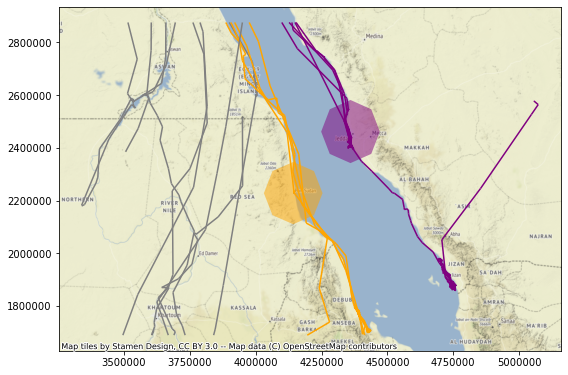

In [28]:
ax = plt.figure(figsize=(9,9)).add_subplot(1,1,1)
        
for traj in relevant:
    place = traj.context
    if place:
        clipped = traj.clip(place_to_point(place).buffer(1,2))
        for clip in clipped:
            print("Individual '{}' was in {} from {} to {}".format(clip.df['individual-local-identifier'].iloc[0], 
                    place.search, clip.get_start_time().date(), clip.get_end_time().date())) 
        ax = traj.plot(ax=ax, for_basemap=True, color=place_to_color[place.search])
    else:
        ax = traj.plot(ax=ax, for_basemap=True, color=place_to_color['Other'])

for place in places:
    plot_place(place, ax=ax)    

ctx.add_basemap(ax)